# K-Nearest Neighbors (KNN)

## Intuition
K-Nearest Neighbors (KNN) is a simple, **instance-based** learning algorithm that makes predictions by comparing a new data point to the *k* most similar points in the training set.  
It’s based on the idea that **similar points tend to have similar labels**.

The algorithm:
1. Stores the training data (no model fitting in the traditional sense).
2. When predicting for a new point:
   - Calculate its distance to all training points.
   - Select the $k$ points with the smallest distances.
   - For classification: pick the most common label among the neighbors.
   - For regression: average the neighbor values.

---

## Why KNN is **Non-Parametric**
- **Non-parametric** means it does not assume a specific functional form for the data (e.g., no fixed number of parameters like slope and intercept in linear regression).
- KNN simply stores the data and makes predictions based on distances — the “model” size grows with the dataset.
- The decision boundary can be arbitrarily complex depending on the training data distribution.

---

## Why KNN is **Non-Linear**
- Even if the relationship between features and labels is highly nonlinear, KNN can adapt, since it makes *local* decisions based on nearby points.
- Decision boundaries in KNN are formed by regions of influence around training points, which are often irregular and non-linear.

---

## Math

### Distance Metric
The most common choice is Euclidean distance:

$$
d(\mathbf{x}_i, \mathbf{x}_j) = \sqrt{\sum_{m=1}^p \left(x_{i,m} - x_{j,m}\right)^2}
$$

where:
- $\mathbf{x}_i$ and $\mathbf{x}_j$ are two feature vectors.
- $p$ is the number of features.

Other distance metrics (Manhattan, Minkowski, cosine similarity) can be used depending on the problem.

---

### Classification Rule
Let $\mathcal{N}_k(\mathbf{x})$ be the set of indices for the $k$ nearest neighbors of $\mathbf{x}$.  
The predicted class is:

$$
\hat{y} = \underset{c \in \mathcal{C}}{\mathrm{argmax}} \ \sum_{i \in \mathcal{N}_k(\mathbf{x})} \mathbf{1}(y_i = c)
$$

where:
- $\mathcal{C}$ is the set of possible classes.
- $\mathbf{1}(\cdot)$ is the indicator function.

---

### Regression Rule
For regression, the prediction is the average of the neighbors’ responses:

$$
\hat{y} = \frac{1}{k} \sum_{i \in \mathcal{N}_k(\mathbf{x})} y_i
$$

---

## Trade-offs
- **Pros:** Simple to understand, no training time, adapts to complex patterns.
- **Cons:** Prediction can be slow for large datasets, sensitive to irrelevant features and scaling, choice of $k$ and distance metric matters.


# Application to Loan Application Dataset
- This was the same dataset used for Logistic Regression, and it's interesting to compare results.

1. We will fit a two-parameter model, visualizing decision boundary
2. We will add in additional variables
3. Comparison to Sklearn

| **Feature**                        | **Description**                                                                    |
| ---------------------------------- | ---------------------------------------------------------------------------------- |
| **person_age**                     | Age of the loan applicant (years).                                                 |
| **person_gender**                  | Gender of the applicant (e.g., Male, Female).                                      |
| **person_education**               | Highest education level attained (e.g., High School, Bachelor, Master, Doctorate). |
| **person_income**                  | Annual income of the applicant.                                                    |
| **person_emp_exp**                 | Work experience in years.                                                          |
| **person_home_ownership**          | Home ownership status (e.g., Rent, Own, Mortgage).                                 |
| **loan_amnt**                      | Amount of the loan requested.                                                      |
| **loan_intent**                    | Purpose of the loan (e.g., Debt Consolidation, Home Improvement).                  |
| **loan_int_rate**                  | Loan interest rate (%) assigned to the applicant.                                  |
| **loan_percent_income**            | Ratio of loan amount to applicant’s income.                                        |
| **cb_person_cred_hist_length**     | Length of the applicant’s credit history in months or years.                       |
| **credit_score**                   | Credit score evaluating applicant’s creditworthiness.                              |
| **previous_loan_defaults_on_file** | Binary indicator if the applicant has past loan defaults (Yes/No).                 |
| **loan_status**                    | Target variable — 1 if loan approved, 0 if rejected.                               |


## Exploratory Data Analysis (EDA)

For a detailed Exploratory Data Analysis (EDA) of the dataset, refer to the **`log_reg_from_scratch.ipynb`** file. It includes:
- Pairplots to visualize relationships between variables.
- Subsetting key explanatory variables such as `person_age`, `person_income`, `loan_amnt`, and `credit_score`.
- Insights into the distribution of `loan_status` and its relationship with other features.

This analysis provides a foundation for understanding the data before applying machine learning algorithms like KNN.

For simplicity, though, we've included some similar plots here.

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("/Users/rykerdolese/Documents/INDE 577/Data-Science-and-Machine-Learning/src")
from mlpackage.preprocess import train_test_split, StandardScaler, OrdinalEncoder
from mlpackage import KNN

## Load the dataset
data = pd.read_csv('loan_data.csv')

## Display the first few rows of the dataset
data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


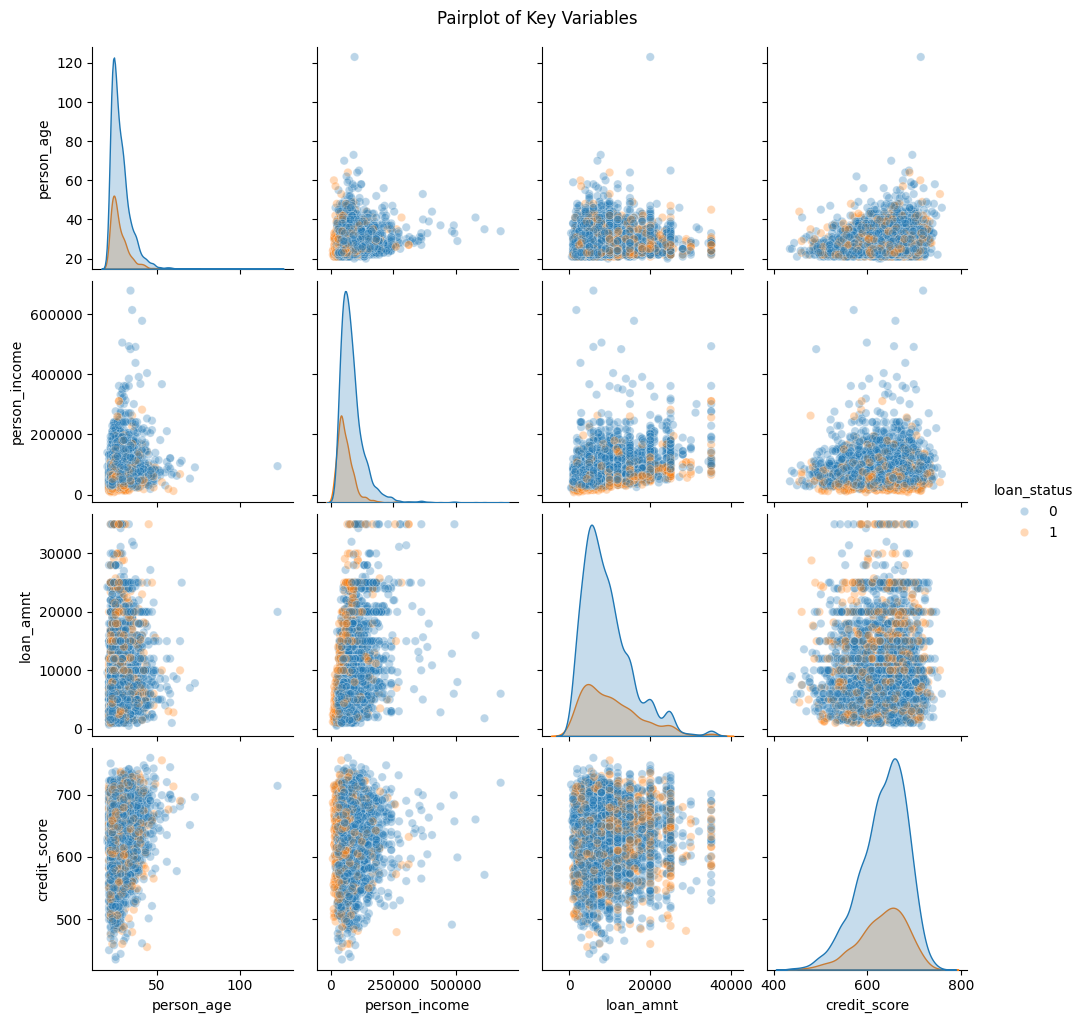

In [6]:
# Extract variables of interest (excluding some for simplicity)
variables_of_interest = ['loan_status', 'person_age', 'person_income', 'loan_amnt', 'credit_score', 'person_education', 'previous_loan_defaults_on_file']
data_subset = data[variables_of_interest]


loan_df_small = data_subset.sample(4000, random_state=42).dropna()

loan_df_small[['person_age', 'person_income', 'loan_amnt', 'credit_score']] = (
    loan_df_small[['person_age', 'person_income', 'loan_amnt', 'credit_score']].apply(pd.to_numeric, errors='coerce')
)

# Pairplot to visualize relationships between variables
sns.pairplot(loan_df_small, hue='loan_status', vars=['person_age', 'person_income', 'loan_amnt', 'credit_score'], plot_kws={'alpha': 0.3})
plt.suptitle('Pairplot of Key Variables', y=1.02)
plt.show()

## Modeling
- The first model will be built on 2 explanatory variables: person income & loan amount

In [25]:
knn_model = KNN(k=5)
X_small = loan_df_small[['person_income', 'loan_amnt']]
y = loan_df_small['loan_status']
X_train_small = X_small.sample(frac=0.8, random_state=42)
X_test_small = X_small.drop(X_train_small.index)
y_train_small = y[X_train_small.index]
y_test_small = y.drop(X_train_small.index)

# Standardize the features using standard scaler from sklearn
# Knn is sensitive to the scale of the features, so we need to standardize them
scaler = StandardScaler()
X_train_small = scaler.fit_transform(X_train_small).values
X_test_small = scaler.transform(X_test_small).values

knn_model.fit(X_train_small, y_train_small)

knn_model.predict(X_test_small)
print(knn_model.accuracy(X_test_small, y_test_small))

0.79375


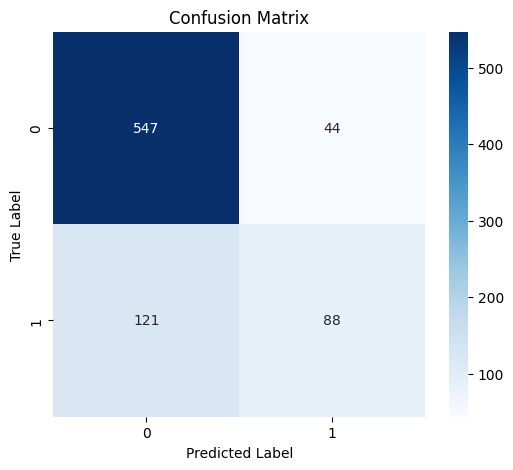

In [26]:
# Get confusion matrix (assuming it's a NumPy array)
cm = knn_model.confusion_matrix(X_test_small, y_test_small)

# Optional: get class names if you have them
class_names = np.unique(y_test_small)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

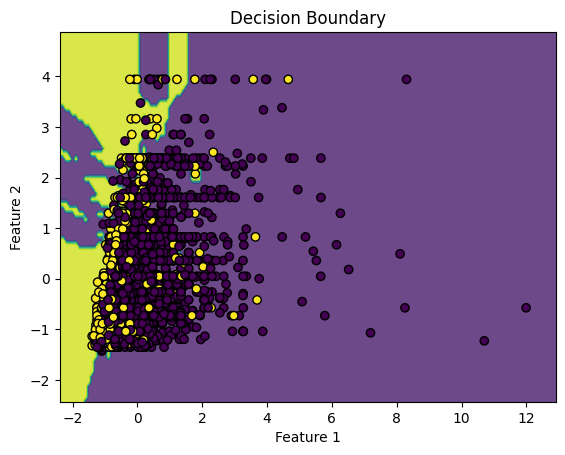

In [27]:
knn_model.draw_decision_boundary(X_train_small, y_train_small)

With just two features, we can visualize the KNN decision boundary. There appears to be a clear line that delineates a prediction of approved vs. unapproved. However, with the purple regions sporadically showing up on the right, the model might be overfitting. It would make sense to tune the hyperparameter K to reduce the likelihood of overfitting.

In [28]:
## Adding Ordinal Encoding for categorical variables
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[['Associate', 'High School', 'Bachelor', 'Master', 'Doctorate'], ['No', 'Yes']])
# This assumes 'person_education' has categories in the order of education level and 'previous_loan_defaults_on_file' has 'No' and 'Yes'.
X, y = loan_df_small.drop('loan_status', axis=1), loan_df_small['loan_status']
X[['person_education', 'previous_loan_defaults_on_file']] = ordinal_encoder.fit_transform(X[['person_education', 'previous_loan_defaults_on_file']])

# Splitting the dataset into training and testing sets
X_train = X.sample(frac=0.8, random_state=42)
X_test = X.drop(X_train.index)
y_train = y[X_train.index]
y_test = y.drop(X_train.index)

In [30]:
# Standardizing the features

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn_model = KNN(k=3)
knn_model.fit(X_train, y_train)

knn_accuracy = knn_model.accuracy(X_test.values, y_test.values)
print(f"KNN Model Accuracy: {knn_accuracy:.2f}")

KNN Model Accuracy: 0.83


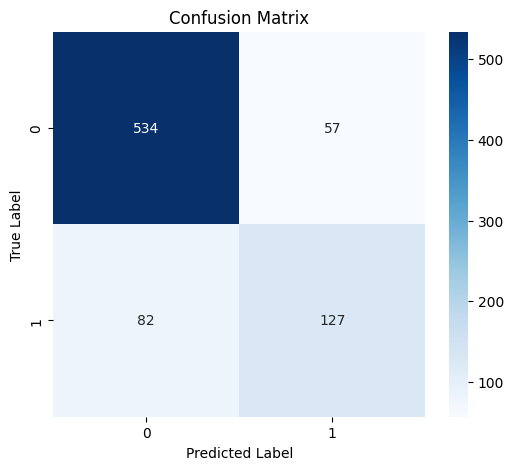

In [43]:
# Get confusion matrix (assuming it's a NumPy array)
cm = knn_model.confusion_matrix(X_test.values, y_test.values)

# Optional: get class names if you have them
class_names = np.unique(y_test)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [44]:
## Comparison to sklearn's KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
sklearn_knn = KNeighborsClassifier(n_neighbors=3)
sklearn_knn.fit(X_train, y_train)
sklearn_accuracy = sklearn_knn.score(X_test, y_test)
print(f"Sklearn KNN Model Accuracy: {sklearn_accuracy:.2f}")

Sklearn KNN Model Accuracy: 0.83


Algorithm seems to work identically!

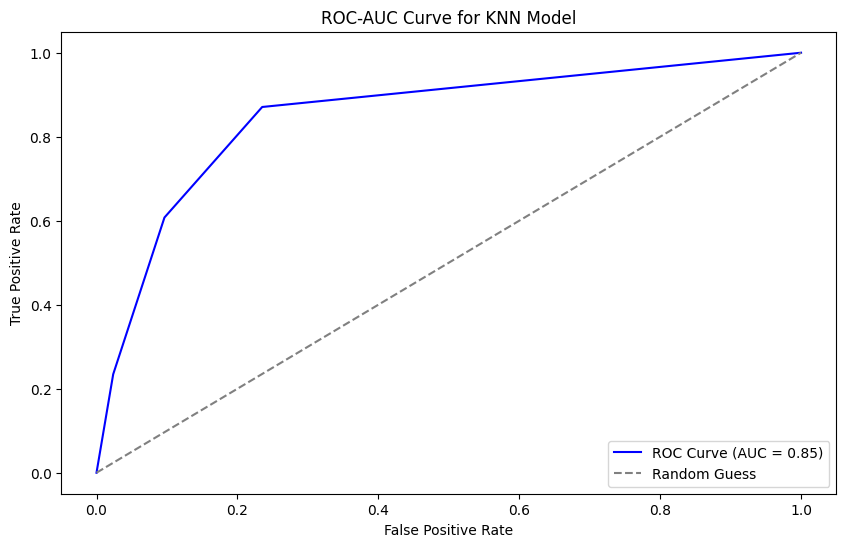

In [45]:
# Let's plot ROC-AUC curve
from sklearn.metrics import roc_curve, auc, classification_report

# Get predicted probabilities for the positive class
y_prob = sklearn_knn.predict_proba(X_test)[:, 1]  # Assuming predict_proba method exists

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for KNN Model')
plt.legend(loc='lower right')
plt.show()

The ROC-AUC curve suggests the model performs well. However, we notice that there are jagged lines for the 'curve', this is because the probability is determined byt the number of observations similar observations pertaining to the corresponding classes. And since we set $K=5$, there are only a distinct number of thresholds.

In [46]:
print(classification_report(y_test, sklearn_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       591
           1       0.69      0.61      0.65       209

    accuracy                           0.83       800
   macro avg       0.78      0.76      0.77       800
weighted avg       0.82      0.83      0.82       800



Model performs well overall, but is slightly worse for the minority class (loans that were accepted). There is a relatively large class imbalance, so this makes sense.